In [55]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random
from torch.utils.data import Dataset,sampler,DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [56]:
from data_functions import *
from models import es_rnn,holt_winters_no_trend

In [75]:
data = pd.read_pickle("aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data=data.set_index('Date')
data.Energy_Generated=pd.to_numeric(data.Energy_Generated)

In [76]:
train_data = data[data.index < '2018-12-31']
test_data =data[data.index > '2018-12-31']

In [79]:
#daily_data_with_weather = train_data[['Condition','Min_Temperature','Max_Temperature','Energy_Generated']]
daily_data_without_weather = train_data[['Energy_Generated']]
weekly_data_mean = train_data.Energy_Generated.resample('W').mean().dropna()
monthly_data_mean = train_data.Energy_Generated.resample('M').mean().dropna()
# normalize features
monthly_data_mean = monthly_data_mean.values.reshape(-1, 1) 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(monthly_data_mean)
scaled = scaled.flatten()
print(scaled)
series = scaled

[0.13441768 0.38489747 0.6370684  0.67410177 0.49414538 0.64361062
 1.         0.83163516 0.718985   0.50741181 0.00512663 0.35208784
 0.10723904 0.31294928 0.69259953 0.70727032 0.6978647  0.87368976
 0.72442228 0.61825686 0.74042202 0.77167076 0.20789704 0.05542411
 0.26061484 0.07652229 0.52764593 0.7625487  0.65509542 0.80131349
 0.67347623 0.78892057 0.62918517 0.48148303 0.34168203 0.31789207
 0.18566964 0.25691909 0.50321636 0.6235625  0.6842383  0.64662789
 0.57175098 0.84901516 0.48724875 0.40339541 0.1632797  0.34543223
 0.22769611 0.07776152 0.49487769 0.90990663 0.81370764 0.66578816
 0.5479743  0.57315996 0.23623069 0.58379196 0.29823328 0.06553484
 0.18114604 0.         0.47620457 0.63734618 0.5487066  0.49294805
 0.78987535 0.69408052 0.6909483  0.2034303  0.18117261 0.12559729]


In [80]:
train=series[:-5]
test=series

In [108]:
sl=sequence_labeling_dataset(train,100,False)
sl_t=sequence_labeling_dataset(test,100,False)

train_dl= DataLoader(dataset=sl,
                      batch_size=4,
                      shuffle=False)

test_dl= DataLoader(dataset=sl_t,
                      batch_size=4,
                      shuffle=False)

In [109]:
hw=es_rnn()

In [110]:
print(sl)

In [111]:
opti = torch.optim.Adam(hw.parameters(), lr=0.01)#,weight_decay=0.0001

torch.Size([4, 60]) tensor([[0.1811, 0.0000, 0.4762, 0.6373, 0.5487, 0.4929, 0.7899, 0.6941, 0.6909,
         0.2034, 0.1812, 0.1256],
        [0.1811, 0.0000, 0.4762, 0.6373, 0.5487, 0.4929, 0.7899, 0.6941, 0.6909,
         0.2034, 0.1812, 0.1256],
        [0.1811, 0.0000, 0.4762, 0.6373, 0.5487, 0.4929, 0.7899, 0.6941, 0.6909,
         0.2034, 0.1812, 0.1256],
        [0.1811, 0.0000, 0.4762, 0.6373, 0.5487, 0.4929, 0.7899, 0.6941, 0.6909,
         0.2034, 0.1812, 0.1256]])


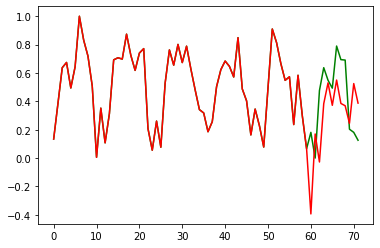

In [112]:
#Initial Prediction 
overall_loss=[]
batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
print(inp,out)
shifts=batch[2].numpy()
pred=hw(inp,shifts)
plt.plot(torch.cat([inp[0],out[0,:]]).detach().numpy(),"g")
plt.plot(torch.cat([inp[0],pred[0,:]]).detach().numpy(),"r")
plt.show()

In [113]:
print(len(series))
#Initial Loss RMSE 
(torch.mean((pred-out)**2))**(1/2)

72


tensor(0.3080, grad_fn=<PowBackward0>)

In [114]:
#Baseline Loss Predicting last value at each step
(torch.mean((inp[0][-1]-out)**2))**(1/2)

tensor(0.4355)

In [115]:
overall_loss_train=[]
overall_loss=[]

In [116]:
for j in tqdm(range(20)):
    loss_list_b=[]
    train_loss_list_b=[]
    #here we use batches of past, and to be forecasted value
    #batches are determined by a random start integer
    for batch in iter(train_dl):

        opti.zero_grad()
        inp=batch[0].float()#.unsqueeze(2)
        out=batch[1].float()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        #it returns the whole sequence atm 
        pred=hw(inp,shifts)
        loss=(torch.mean((pred-out)**2))**(1/2)
        train_loss_list_b.append(loss.detach().cpu().numpy())
        
        loss.backward()
        opti.step()


    #here we use all the available values to forecast the future ones and eval on it
    for batch in iter(test_dl):
        inp=batch[0].float()#.unsqueeze(2)
        out=batch[1].float()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        pred=hw(inp,shifts)
        #loss=torch.mean(torch.abs(pred-out))
        loss=(torch.mean((pred-out)**2))**(1/2)
        loss_list_b.append(loss.detach().cpu().numpy())
    
 
    print(np.mean(loss_list_b))
    print(np.mean(train_loss_list_b))
    overall_loss.append(np.mean(loss_list_b))
    overall_loss_train.append(np.mean(train_loss_list_b))

  5%|▌         | 1/20 [02:07<40:28, 127.82s/it]

0.47767138
0.003930198


 10%|█         | 2/20 [04:17<38:32, 128.49s/it]

0.4685169
0.0018805912


 15%|█▌        | 3/20 [06:27<36:28, 128.75s/it]

0.46093497
0.0015350694


 20%|██        | 4/20 [08:39<34:38, 129.88s/it]

0.45252198
0.0012561014


 25%|██▌       | 5/20 [10:45<32:10, 128.67s/it]

0.4441182
0.0010719151


 30%|███       | 6/20 [12:55<30:05, 129.00s/it]

0.43216226
0.0009742615


 35%|███▌      | 7/20 [15:06<28:05, 129.67s/it]

0.4262
0.00093382475


 40%|████      | 8/20 [17:14<25:51, 129.28s/it]

0.42325348
0.00093048724


 45%|████▌     | 9/20 [19:22<23:35, 128.69s/it]

0.42184302
0.0009148444


 50%|█████     | 10/20 [21:28<21:20, 128.02s/it]

0.41953295
0.0009247997


 55%|█████▌    | 11/20 [23:36<19:11, 127.90s/it]

0.41858768
0.0009227358


 60%|██████    | 12/20 [25:43<17:01, 127.75s/it]

0.41815898
0.00090658944


 65%|██████▌   | 13/20 [27:50<14:51, 127.36s/it]

0.4175143
0.0008598177


 70%|███████   | 14/20 [29:56<12:42, 127.16s/it]

0.41624218
0.0008771754


 75%|███████▌  | 15/20 [32:03<10:34, 126.96s/it]

0.41731006
0.0008695475


 80%|████████  | 16/20 [34:09<08:26, 126.74s/it]

0.41752794
0.00085423625


 85%|████████▌ | 17/20 [36:17<06:21, 127.19s/it]

0.41690308
0.00082647457


 90%|█████████ | 18/20 [38:25<04:14, 127.24s/it]

0.41678193
0.0008919762


 95%|█████████▌| 19/20 [40:35<02:08, 128.05s/it]

0.4176666
0.00082060526


100%|██████████| 20/20 [42:53<00:00, 128.70s/it]

0.4178632
0.000867568


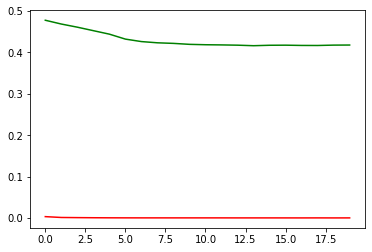

In [117]:
#Plot of Train and Validatiaon Loss, we nicely converge
plt.plot(overall_loss,"g")
plt.plot(overall_loss_train,"r")

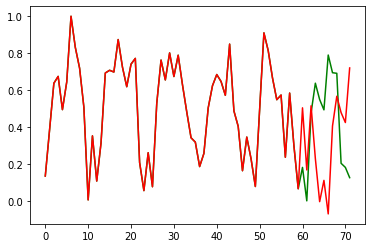

In [118]:
#Forecasting on the Validation set

batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
pred=hw(torch.cat([inp,out],dim=1),shifts)

#plt.plot(torch.cat([inp,out,pred],dim=1)[0].detach().numpy(),"r")


plt.plot(torch.cat([inp[0],out[0,:]]).detach().numpy(),"g")
plt.plot(torch.cat([inp[0],pred[0,:]]).detach().numpy(),"r")
plt.show()

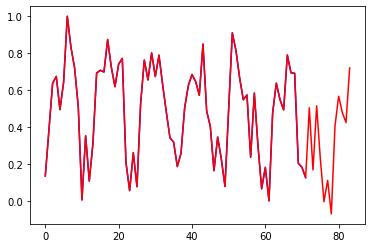

In [119]:
#Forecasting to the Future looks good.

batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()

pred=hw(torch.cat([inp,out],dim=1),shifts)
plt.plot(torch.cat([inp,out],dim=1)[0].detach().numpy(),"b")
plt.plot(torch.cat([inp,out,pred],dim=1)[0].detach().numpy(),"r")


plt.show()

In [120]:
param_list=[]
for params in hw.parameters():
    param_list.append(params)
param_list=torch.sigmoid(params[0:2]).detach().numpy()

param_list

array([0.5365787, 0.4887148], dtype=float32)